In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["first_active_month"])
test = pd.read_csv("data/test.csv", parse_dates=["first_active_month"])
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [3]:
# Handle missing values
print(train.isnull().sum())
print(test.isnull().sum())

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64


In [4]:
test = test.dropna(subset=['first_active_month'])
print(train.isnull().sum())
print(test.isnull().sum())

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64


In [5]:
# Extract month from first_active_month
train['month'] = train['first_active_month'].dt.month
test['year'] = test['first_active_month'].dt.month

# Extract year from first_active_month
train['year'] = train['first_active_month'].dt.year
test['year'] = test['first_active_month'].dt.year

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017


In [6]:
historical_transactions = pd.read_csv("data/historical_transactions.csv")
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [7]:
# Calculate number of historical transactions by card_id
purchases = historical_transactions.groupby("card_id")
purchases = purchases["purchase_amount"].agg(['count', 'sum', 'mean', 'std', 'min', 'max']).reset_index()
purchases.columns = [
    "card_id",
    "num_hist_transactions",
    "sum_hist_transactions",
    "mean_hist_transactions",
    "std_hist_transactions",
    "min_hist_transactions",
    "max_hist_transactions"
]

# Merge with training and test set
train = train.merge(purchases, on="card_id", how="left")
test = test.merge(purchases, on="card_id", how="left")

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,num_hist_transactions,sum_hist_transactions,mean_hist_transactions,std_hist_transactions,min_hist_transactions,max_hist_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,260,-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,350,-210.006336,-0.600018,0.384967,-0.742400,4.630299
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,43,-29.167391,-0.678311,0.087380,-0.730138,-0.145847
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,77,-49.491364,-0.642745,0.261624,-0.740897,1.445596
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,133,-48.687656,-0.366073,1.352094,-0.746156,7.193041


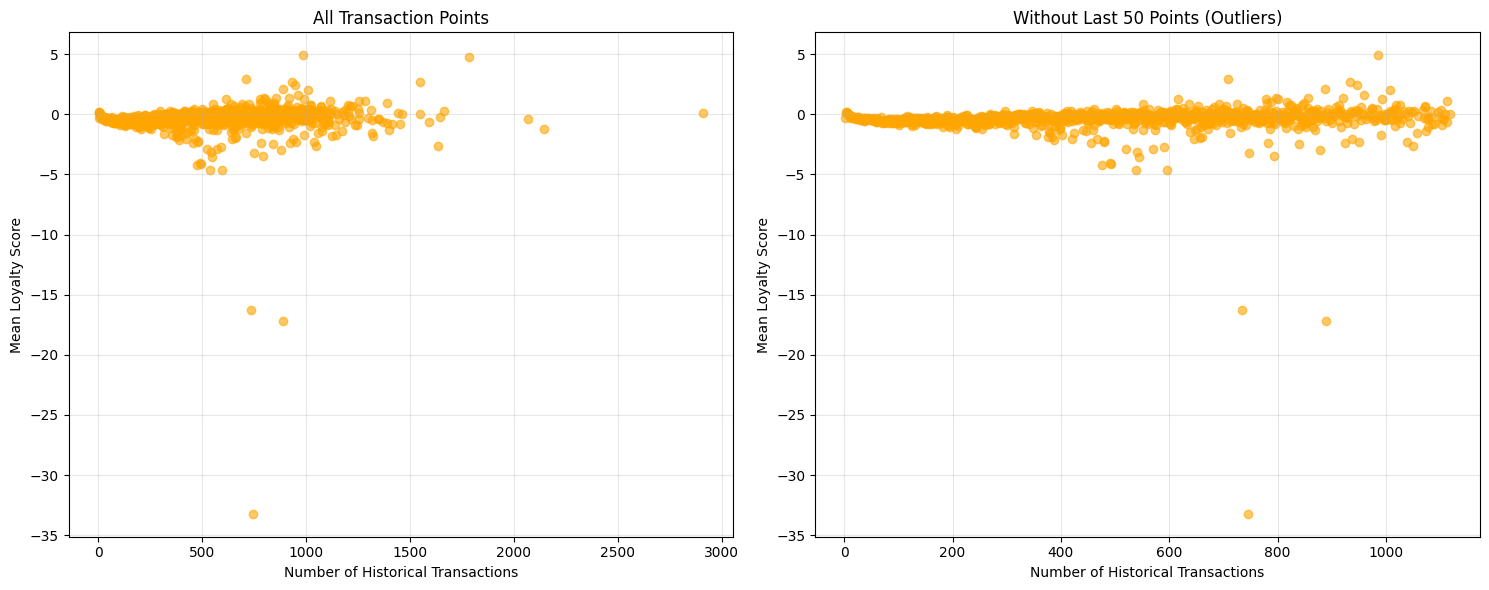

In [8]:
# Calculate mean loyalty score by number of historical transactions
cnt_srs = train.groupby("num_hist_transactions")["target"].mean()
cnt_srs = cnt_srs.sort_index()

# Create two subplots
plt.figure(figsize=(15, 6))

# Plot 1: All points
plt.subplot(1, 2, 1)
plt.scatter(cnt_srs.index[::-1], cnt_srs.values[::-1], color='orange', alpha=0.6)
plt.title('All Transaction Points')
plt.xlabel('Number of Historical Transactions')
plt.ylabel('Mean Loyalty Score')
plt.grid(True, alpha=0.3)

# Plot 2: Without last 50 points
plt.subplot(1, 2, 2)
cnt_srs_filtered = cnt_srs[:-50]  # TODO: OUTLIERS
plt.scatter(cnt_srs_filtered.index[::-1], cnt_srs_filtered.values[::-1], color='orange', alpha=0.6)
plt.title('Without Last 50 Points (Outliers)')
plt.xlabel('Number of Historical Transactions')
plt.ylabel('Mean Loyalty Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()

/tmp/ipykernel_294660/4228394743.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_srs_binned = train.groupby("binned_num_hist_transactions")["target"].mean()



Mean loyalty score by binned transaction counts:
binned_num_hist_transactions
(0, 10]         0.018791
(10, 20]       -0.239937
(20, 30]       -0.322822
(30, 40]       -0.396614
(40, 50]       -0.383919
(50, 75]       -0.487289
(75, 100]      -0.545137
(100, 150]     -0.500725
(150, 200]     -0.498041
(200, 500]     -0.435845
(500, 10000]   -0.339671
Name: target, dtype: float64


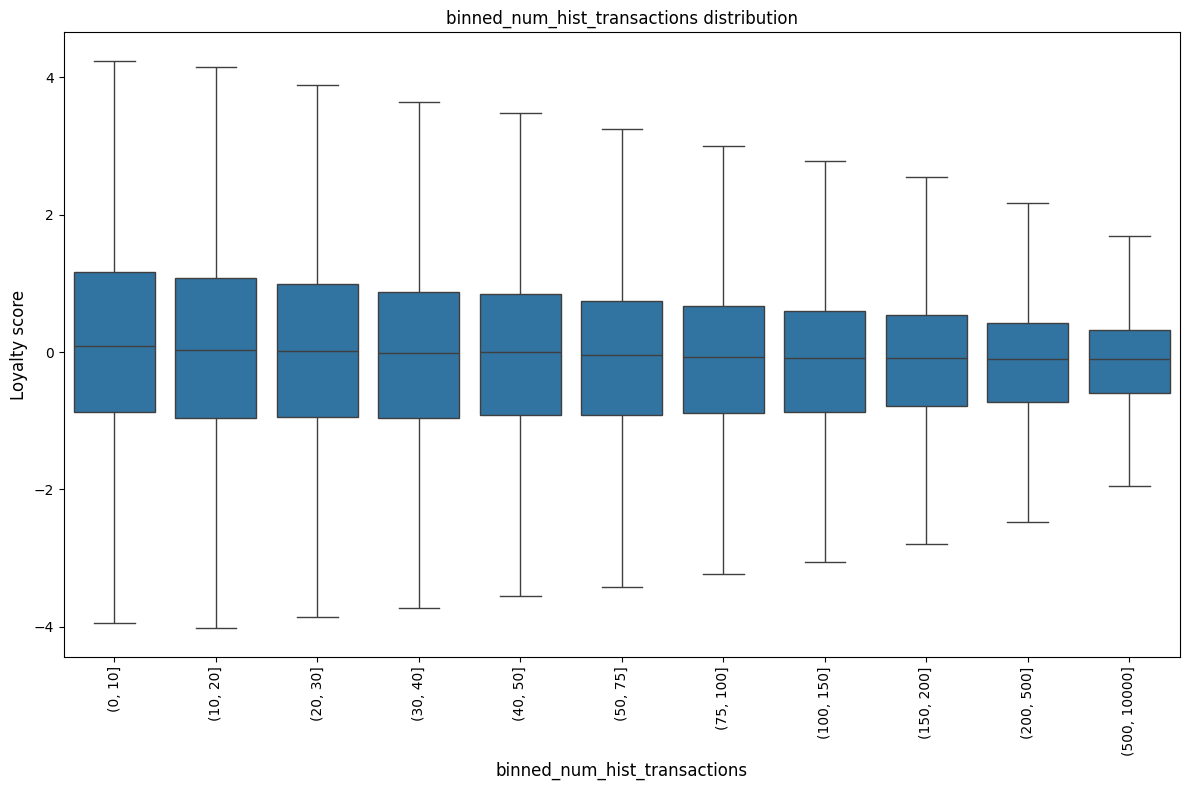

In [9]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train['binned_num_hist_transactions'] = pd.cut(train['num_hist_transactions'], bins)

# Calculate mean loyalty score by binned transactions
cnt_srs_binned = train.groupby("binned_num_hist_transactions")["target"].mean()
print("\nMean loyalty score by binned transaction counts:")
print(cnt_srs_binned)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y="target", data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.tight_layout()

In [10]:
new_merchant_transactions = pd.read_csv("data/new_merchant_transactions.csv")
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [11]:
# Calculate number of new merchant transactions by card_id
transactions = new_merchant_transactions.groupby("card_id")
transactions = transactions["purchase_amount"].agg(['count', 'sum', 'mean', 'std', 'min', 'max']).reset_index()
transactions.columns = [
    "card_id",
    "num_new_merchant_transactions",
    "sum_new_merchant_transactions",
    "mean_new_merchant_transactions",
    "std_new_merchant_transactions",
    "min_new_merchant_transactions",
    "max_new_merchant_transactions"
]

# Merge with training and test set
train = train.merge(transactions, on="card_id", how="left")
test = test.merge(transactions, on="card_id", how="left")

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,num_hist_transactions,sum_hist_transactions,...,std_hist_transactions,min_hist_transactions,max_hist_transactions,binned_num_hist_transactions,num_new_merchant_transactions,sum_new_merchant_transactions,mean_new_merchant_transactions,std_new_merchant_transactions,min_new_merchant_transactions,max_new_merchant_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,260,-165.968739,...,0.212139,-0.739395,2.258395,"(200, 500]",23.0,-13.244202,-0.575835,0.135812,-0.724368,-0.296112
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,350,-210.006336,...,0.384967,-0.742400,4.630299,"(200, 500]",6.0,-4.355735,-0.725956,0.014326,-0.739410,-0.701858
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,43,-29.167391,...,0.087380,-0.730138,-0.145847,"(40, 50]",1.0,-0.700326,-0.700326,NaN,-0.700326,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,77,-49.491364,...,0.261624,-0.740897,1.445596,"(75, 100]",7.0,-4.654372,-0.664910,0.065882,-0.734135,-0.566740
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,133,-48.687656,...,1.352094,-0.746156,7.193041,"(100, 150]",36.0,-19.926237,-0.553507,0.223821,-0.739395,0.450886


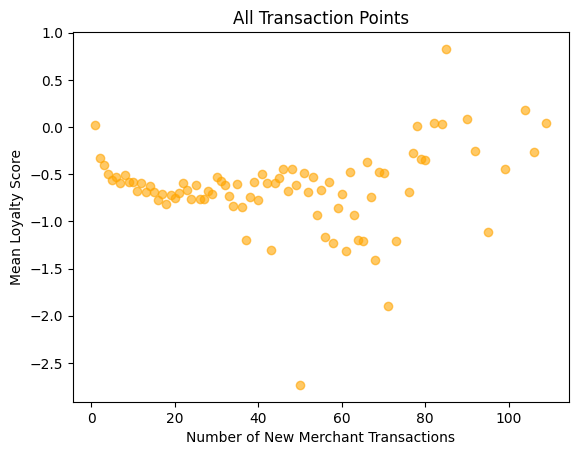

In [12]:
# Calculate mean loyalty score by number of new merchant transactions
cnt_srs = train.groupby("num_new_merchant_transactions")["target"].mean()
cnt_srs = cnt_srs.sort_index()

# All points
plt.scatter(cnt_srs.index[::-1], cnt_srs.values[::-1], color='orange', alpha=0.6)
plt.title('All Transaction Points')
plt.xlabel('Number of New Merchant Transactions')
plt.ylabel('Mean Loyalty Score')
plt.show()

/tmp/ipykernel_294660/3964038241.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_srs_binned = train.groupby("num_new_merchant_transactions")["target"].mean()



Mean loyalty score by binned transaction counts:
num_new_merchant_transactions
(0, 10]       -0.385467
(10, 20]      -0.685215
(20, 30]      -0.678870
(30, 40]      -0.724951
(40, 50]      -0.731390
(50, 75]      -0.792230
(75, 10000]   -0.145949
Name: target, dtype: float64


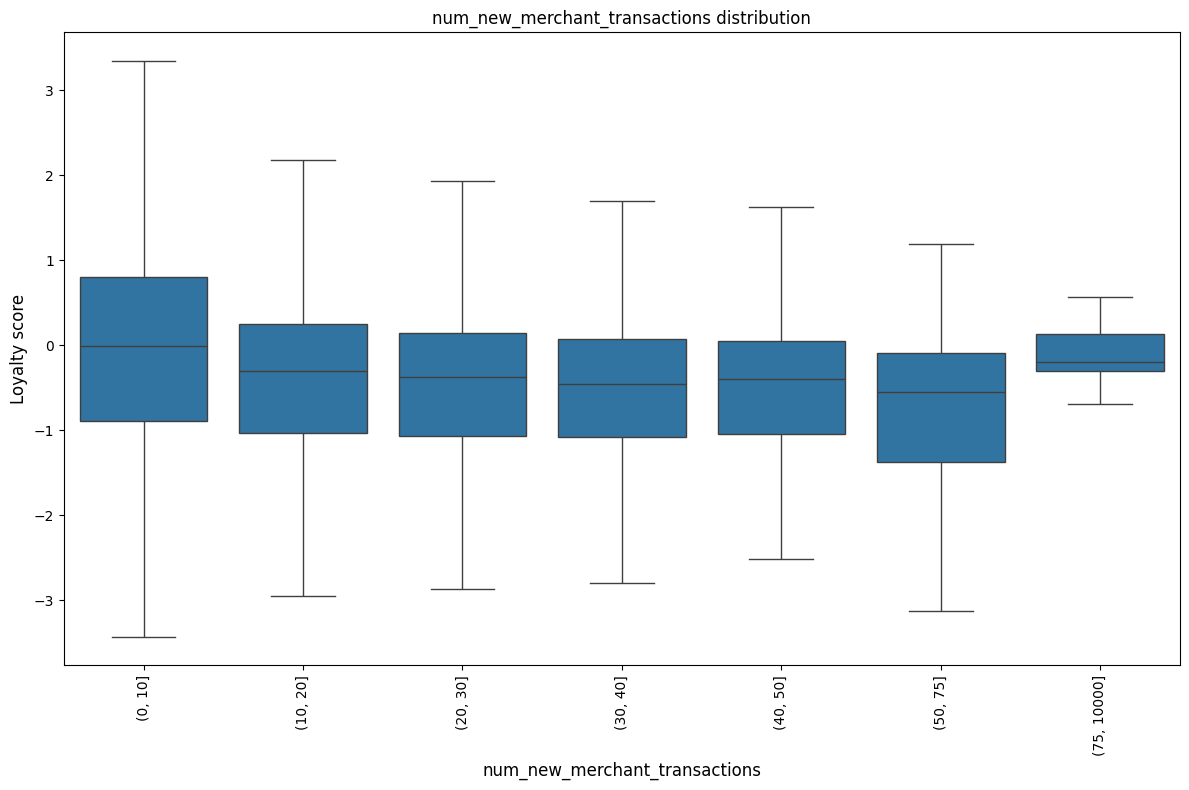

In [13]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train['num_new_merchant_transactions'] = pd.cut(train['num_new_merchant_transactions'], bins)

# Calculate mean loyalty score by binned transactions
cnt_srs_binned = train.groupby("num_new_merchant_transactions")["target"].mean()
print("\nMean loyalty score by binned transaction counts:")
print(cnt_srs_binned)

plt.figure(figsize=(12,8))
sns.boxplot(x="num_new_merchant_transactions", y="target", data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('num_new_merchant_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("num_new_merchant_transactions distribution")
plt.tight_layout()